### Setup

In [1]:
#Adjust the number of threads to your system
NT_shared = 8
NT_task = 32
Ngpu_runs = 10 #Set to 100 for more accurate results, much smaller standard deviation.
Ncpu_runs = 10 #Set to 100 for more accurate results, much smaller standard deviation.
Ncpu_warmup = 5 #Warmup caches and branch predictor.
Ngpu_warmup = 1 #No branch prediction on GPU, but if prefetching is disabled, the first run will fetch data.
#Change this number if the simulation is taking too long.
#Setting this number to -1 will reduce the batch sizes by 1 power of 2
OFFSET_BS = 0
omp_shared_setting = f"OMP_NUM_THREADS={int(NT_shared)} OMP_PROC_BIND=TRUE" 
omp_task_setting = f"OMP_NUM_THREADS={int(NT_task)} OMP_PROC_BIND=TRUE"

import matplotlib.pyplot as plt
import colorsys
from matplotlib import rcParams as rc
import numpy as np
import pandas as pd
import os

import subprocess
import platform

# Run the command and capture its output
output = subprocess.check_output(['nvidia-smi', '-L'])

# Convert the byte string to a regular string
output_str = output.decode('utf-8')

# Count the number of lines in the output
num_gpus = len(output_str.strip().split('\n'))

hostname = platform.node()
# Print the number of GPUs found
print(f'Found {num_gpus} GPUs on {hostname}')

if not os.path.exists("output"):
    os.mkdir("output")

if not os.path.exists("output/" + hostname):
    os.mkdir("output/" + hostname)

if not os.path.exists("output/" + hostname + "/figures"):
    os.mkdir("output/" + hostname + "/figures")

rc["legend.markerscale"] = 2.0
rc["legend.framealpha"] = 0
rc["legend.labelspacing"] = 0.1
rc['figure.figsize'] = (20,10)
rc['axes.autolimit_mode'] = 'data'
rc['axes.xmargin'] = 0
rc['axes.ymargin'] = 0.10
rc['axes.titlesize'] = 30
rc['axes.labelsize'] = 24
rc['xtick.labelsize'] = 20
rc['ytick.labelsize'] = 20
rc['axes.grid'] = True
rc['grid.linestyle'] = '-'
rc['grid.alpha'] = 0.2
rc['legend.fontsize'] = 20
rc['legend.loc'] = 'upper left'
rc["figure.autolayout"] = True
rc["savefig.dpi"] = 300

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2"]
CD = { "Baseline" : colors[0], "Shared" : colors[1], "Task" : colors[2], "GPU_V0" : colors[3], "GPU_V1" : colors[4], "2 GPU_V0" :  colors[5] ,"2 GPU_V1" : colors[6]}

def adjust_brightness(color, amount):
    """Adjust the brightness of a color by a given amount (-1 to 1)."""
    # Convert the color to the RGB color space
    r, g, b = tuple(int(color[i:i+2], 16) for i in (1, 3, 5))
    # Convert the color to the HLS color space
    h, l, s = colorsys.rgb_to_hls(r/255, g/255, b/255)
    # Modify the lightness value
    l = max(0, min(1, l + amount))
    # Convert the color back to RGB and return it
    r, g, b = tuple(round(c * 255) for c in colorsys.hls_to_rgb(h, l, s))
    return f"#{r:02x}{g:02x}{b:02x}"
# Modify the brightness of the colors
colors = [adjust_brightness(color, 0.2) for color in colors]
CD = { "Baseline" : 'r', "Shared" : colors[1], "Task" : colors[2], "GPU_V0" : colors[3], "GPU_V1" : colors[4], "2 GPU_V0" :  colors[5] ,"2 GPU_V1" : colors[0]}

KName0 = r"CUDA Kernel 0"
KName1 = r"CUDA Kernel 1"
TaskName = r"OpenMP Task Parallel [$N_T$ = " + f"{NT_task}]"
SharedName = r"OpenMP Shared Memory [$N_T$ = " + f"{NT_shared}]"

Found 2 GPUs on threadripper00


### Create files to store results, if they already exist, empty them.

In [2]:
path = f'/{os.getcwd()}/output/{hostname}/'
buildpath = f'/{os.getcwd()}/build/'
fname_base = f'{path}base.csv'
fname_one_gpu_v0 = f'{path}one_gpu_v0.csv'
fname_one_gpu_v1 = f'{path}one_gpu_v1.csv'
fname_multi_gpu_v0 = f'{path}multi_gpu_v0.csv'
fname_multi_gpu_v1 = f'{path}multi_gpu_v1.csv'
fname_multi_gpu_weak = f'{path}multi_gpu_weak.csv'
fname_omp_shared = f'{path}omp_shared.csv'
fname_omp_task = f'{path}omp_task.csv'

def reset_file(filename):
    # Check if the file already exists
    if os.path.isfile(filename):
        # If it does, empty it by opening it in write mode with the 'truncate' option
        with open(filename, 'w', newline='') as f:
            f.truncate()
    else:
        # If it doesn't, create an empty file by opening it in write mode
        with open(filename, 'w', newline='') as f:
            pass

reset_file(fname_base)
reset_file(fname_one_gpu_v0)
reset_file(fname_one_gpu_v1)
reset_file(fname_multi_gpu_v0)
reset_file(fname_multi_gpu_v1)
reset_file(fname_multi_gpu_weak)
reset_file(fname_omp_shared)
reset_file(fname_omp_task)



### Run the batch size experiment

In [3]:
fname_omp_shared_bs = f'{path}omp_shared_bs.csv'
fname_omp_task_bs = f'{path}omp_task_bs.csv'
fname_single_gpu_bs = f'{path}single_gpu_bs.csv'
reset_file(fname_omp_shared_bs)
reset_file(fname_omp_task_bs)
reset_file(fname_single_gpu_bs)


for i in range(0,20):
    os.system(f'{omp_shared_setting} {buildpath}benchmarks/omp_multicore 200 {str(2**i)} {Ncpu_runs} {Ncpu_warmup} 0 {fname_omp_shared_bs}')
    os.system(f'{omp_task_setting} {buildpath}benchmarks/omp_multicore 200 {str(2**i)} {Ncpu_runs} {Ncpu_warmup} 1 {fname_omp_task_bs}')
    if(num_gpus>0):
        os.system(f'{buildpath}benchmarks/single_gpu 200 {str(2**i)} {Ngpu_runs} {Ngpu_warmup} 0 {fname_single_gpu_bs}')

Mean Time per Graph: 10979 +/- 276.865 ns
Mean Time per Graph: 24967.8 +/- 628.366 ns
Mean Time per Graph: 13081 +/- 422.231 ns
Mean Time per Graph: 9708.33 +/- 100.654 ns
Mean Time per Graph: 17403.9 +/- 249.133 ns
Mean Time per Graph: 6994.9 +/- 323.7 ns
Mean Time per Graph: 7971.67 +/- 137.891 ns
Mean Time per Graph: 12147.8 +/- 1115.83 ns
Mean Time per Graph: 3471.07 +/- 167.183 ns
Mean Time per Graph: 8704.03 +/- 102.473 ns
Mean Time per Graph: 7270.97 +/- 213.963 ns
Mean Time per Graph: 1866.74 +/- 60.6906 ns
Mean Time per Graph: 8741.94 +/- 253.399 ns
Mean Time per Graph: 2843.96 +/- 62.9484 ns
Mean Time per Graph: 865.062 +/- 31.8916 ns
Mean Time per Graph: 9287.08 +/- 86.9654 ns
Mean Time per Graph: 1756.7 +/- 81.1183 ns
Mean Time per Graph: 437.984 +/- 15.2138 ns
Mean Time per Graph: 9590.47 +/- 102.772 ns
Mean Time per Graph: 1483.45 +/- 97.5616 ns
Mean Time per Graph: 219.491 +/- 12.9214 ns
Mean Time per Graph: 10444.8 +/- 31.1586 ns
Mean Time per Graph: 1300.22 +/- 17.7791

### Plot the batch size experiment

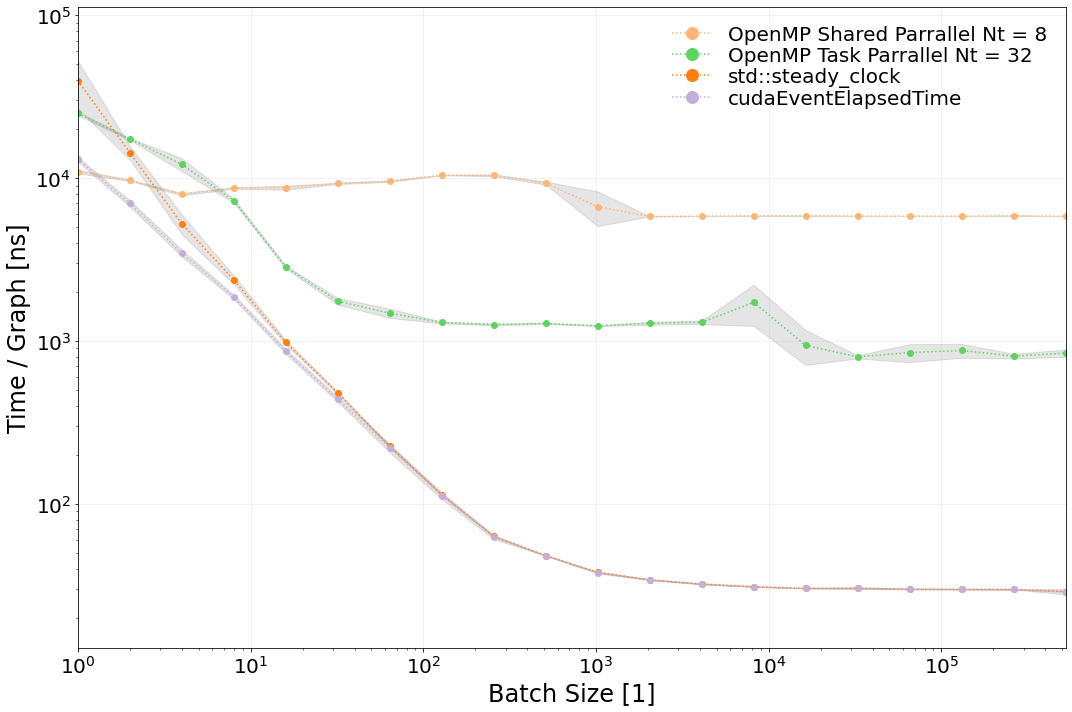

In [4]:
df_omp_shared_bs = pd.read_csv(fname_omp_shared_bs)
df_omp_task_bs = pd.read_csv(fname_omp_task_bs)
df_single_gpu_bs = pd.read_csv(fname_single_gpu_bs)

import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, mark_inset)
fig,ax = plt.subplots(figsize=(15,10))
def add_line(ax, BS, T, SD, label, color, marker, linestyle):
    ax.plot(BS, T, marker=marker, color=color, label=label, linestyle=linestyle)
    ax.fill_between(BS, T - SD, T + SD, alpha=0.1, color='k')
 
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel("Time / Graph [ns]")
ax.set_xlabel("Batch Size [1]")
add_line(ax, df_omp_shared_bs["BS"].to_numpy(), df_omp_shared_bs["T"].to_numpy(), df_omp_shared_bs["TSD"].to_numpy(), "OpenMP Shared Parrallel Nt = 8", CD["Shared"], 'o', ':')
add_line(ax, df_omp_task_bs["BS"].to_numpy(), df_omp_task_bs["T"].to_numpy(), df_omp_task_bs["TSD"].to_numpy(), "OpenMP Task Parrallel Nt = 32", CD["Task"], 'o', ':')
if(num_gpus>0):
    add_line(ax, df_single_gpu_bs["BS"].to_numpy(), df_single_gpu_bs["T"].to_numpy() + df_single_gpu_bs["TD"].to_numpy(), df_single_gpu_bs["TDSD"].to_numpy(), "std::steady_clock", 'tab:orange', 'o', ':')
    add_line(ax, df_single_gpu_bs["BS"].to_numpy(), df_single_gpu_bs["T"].to_numpy(), df_single_gpu_bs["TSD"].to_numpy(), "cudaEventElapsedTime", CD["GPU_V1"], 'o', ':')
ax.legend(loc='best')
plt.savefig(f'{path}figures/batch_size_benchmark.pdf', bbox_inches='tight')

### Run the benchmarks

In [5]:



reset_file(fname_base)
reset_file(fname_one_gpu_v0)
reset_file(fname_one_gpu_v1)
reset_file(fname_multi_gpu_v0)
reset_file(fname_multi_gpu_v1)
reset_file(fname_omp_shared)
reset_file(fname_omp_task)
reset_file(fname_multi_gpu_weak)

for i in range(20,201,2):
    os.system(f'{buildpath}benchmarks/baseline {i} {2**(6+OFFSET_BS)} {Ncpu_runs} {Ncpu_warmup} 0 {fname_base}')
    os.system(f'{omp_shared_setting} {buildpath}benchmarks/omp_multicore {i} {2**(10+OFFSET_BS)} {Ncpu_runs} {Ncpu_warmup} 0 {fname_omp_shared}')
    os.system(f'{omp_task_setting} {buildpath}benchmarks/omp_multicore {i} {2**(18+OFFSET_BS)} {Ncpu_runs} {Ncpu_warmup} 1 {fname_omp_task}')
    if(num_gpus>0):
        os.system(f'{buildpath}benchmarks/single_gpu {i} {2**(20+OFFSET_BS)} {Ngpu_runs} {Ngpu_warmup} 0 {fname_one_gpu_v0}')
        os.system(f'{buildpath}benchmarks/single_gpu {i} {2**(20+OFFSET_BS)} {Ngpu_runs} {Ngpu_warmup} 1 {fname_one_gpu_v1}')
        os.system(f'{buildpath}benchmarks/multi_gpu {i} {2**(20+OFFSET_BS)} {Ngpu_runs} {Ngpu_warmup} 0 {fname_multi_gpu_v0}')
        os.system(f'{buildpath}benchmarks/multi_gpu {i} {2**(20+OFFSET_BS)} {Ngpu_runs} {Ngpu_warmup} 1 {fname_multi_gpu_v1}')
        os.system(f'{buildpath}benchmarks/multi_gpu {i} {num_gpus*2**(20+OFFSET_BS)} {Ngpu_runs} {Ngpu_warmup} 1 {fname_multi_gpu_weak}')



Mean Time per Graph: 20497 +/- 292.273 ns
Mean Time per Graph: 3134.5 +/- 17.2075 ns
Mean Time per Graph: 89.8911 +/- 9.92803 ns
Mean Time per Graph: 6.65907 +/- 0.0178171 ns
Mean Time per Graph: 6.81219 +/- 0.0200663 ns
Mean Time per Graph: 4.84678 +/- 0.0614415 ns
Mean Time per Graph: 4.98316 +/- 0.0799633 ns
Mean Time per Graph: 4.14089 +/- 0.0373585 ns
N must be even and between 20 and 200 and not equal to 22.
N must be even and between 20 and 200 and not equal to 22.
N must be even and between 20 and 200 and not equal to 22.
N must be even and between 20 and 200 and not equal to 22.
N must be even and between 20 and 200 and not equal to 22.
N must be even and between 20 and 200 and not equal to 22.
N must be even and between 20 and 200 and not equal to 22.
N must be even and between 20 and 200 and not equal to 22.
Mean Time per Graph: 9094.44 +/- 22.1422 ns
Mean Time per Graph: 2655.21 +/- 135.301 ns
Mean Time per Graph: 92.1437 +/- 1.59678 ns
Mean Time per Graph: 7.84813 +/- 0.01

### Baseline Benchmark Plot

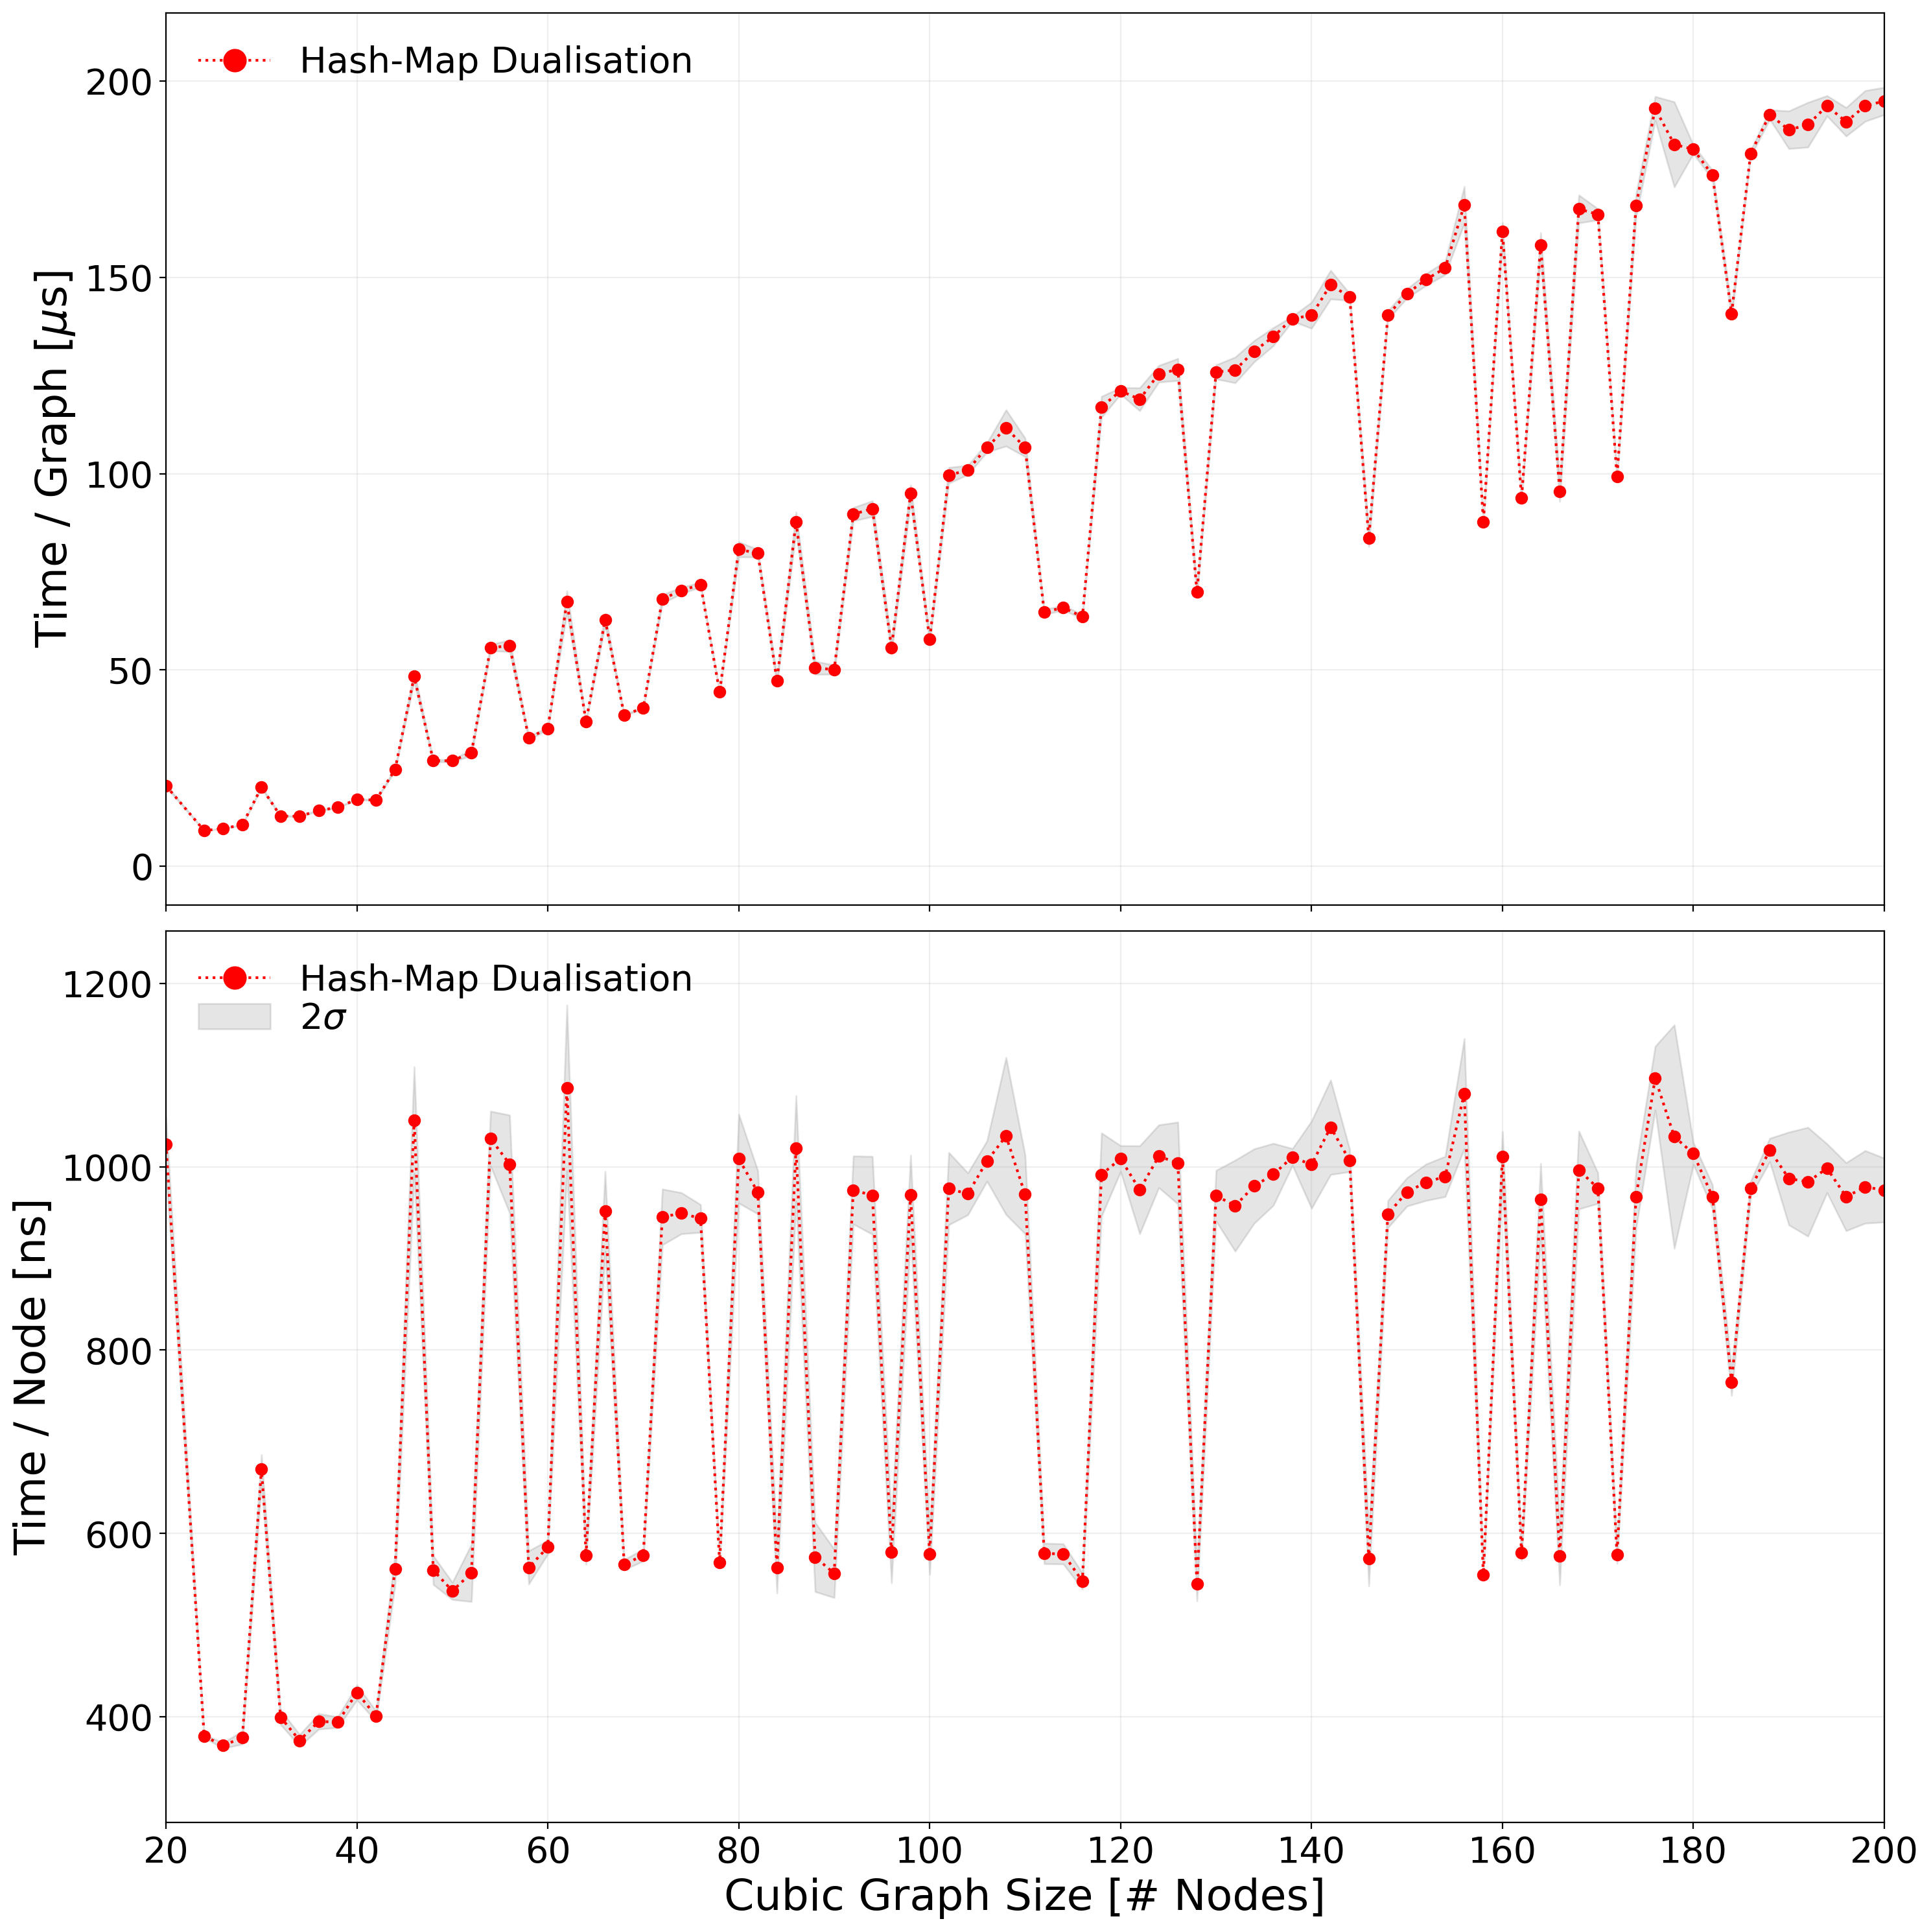

In [6]:
df_base = pd.read_csv(fname_base)

fig, ax = plt.subplots(figsize=(15,15), nrows=2, sharex=True, dpi=200)
ax[0].plot(df_base["N"].to_numpy(), df_base["T"].to_numpy()/1e3, 'o:', color=CD["Baseline"], label="Hash-Map Dualisation")
ax[0].fill_between(df_base["N"].to_numpy(), (df_base["T"].to_numpy() - df_base["TSD"].to_numpy())/1e3, (df_base["T"].to_numpy() + df_base["TSD"].to_numpy())/1e3, alpha=0.1, color='k')
ax[0].set_ylabel(r"Time / Graph [$\mu$s]")
ax[0].legend()

ax[1].plot(df_base["N"].to_numpy(), df_base["T"].to_numpy() / df_base["N"].to_numpy(), 'o:', color=CD["Baseline"], label="Hash-Map Dualisation")
ax[1].fill_between(df_base["N"].to_numpy(), (df_base["T"].to_numpy() - df_base["TSD"].to_numpy()*2) / df_base["N"].to_numpy(), (df_base["T"].to_numpy()+df_base["TSD"].to_numpy()*2) / df_base["N"].to_numpy(), color='k', alpha=0.1, label=r"2$\sigma$")
ax[1].set_ylabel(r"Time / Node [ns]")
ax[1].set_xlabel(r"Cubic Graph Size [# Nodes]")
ax[1].legend()
plt.savefig(path + "figures/baseline.pdf", bbox_inches='tight')


### OMP Shared-memory and Task-parallel Benchmark Plot

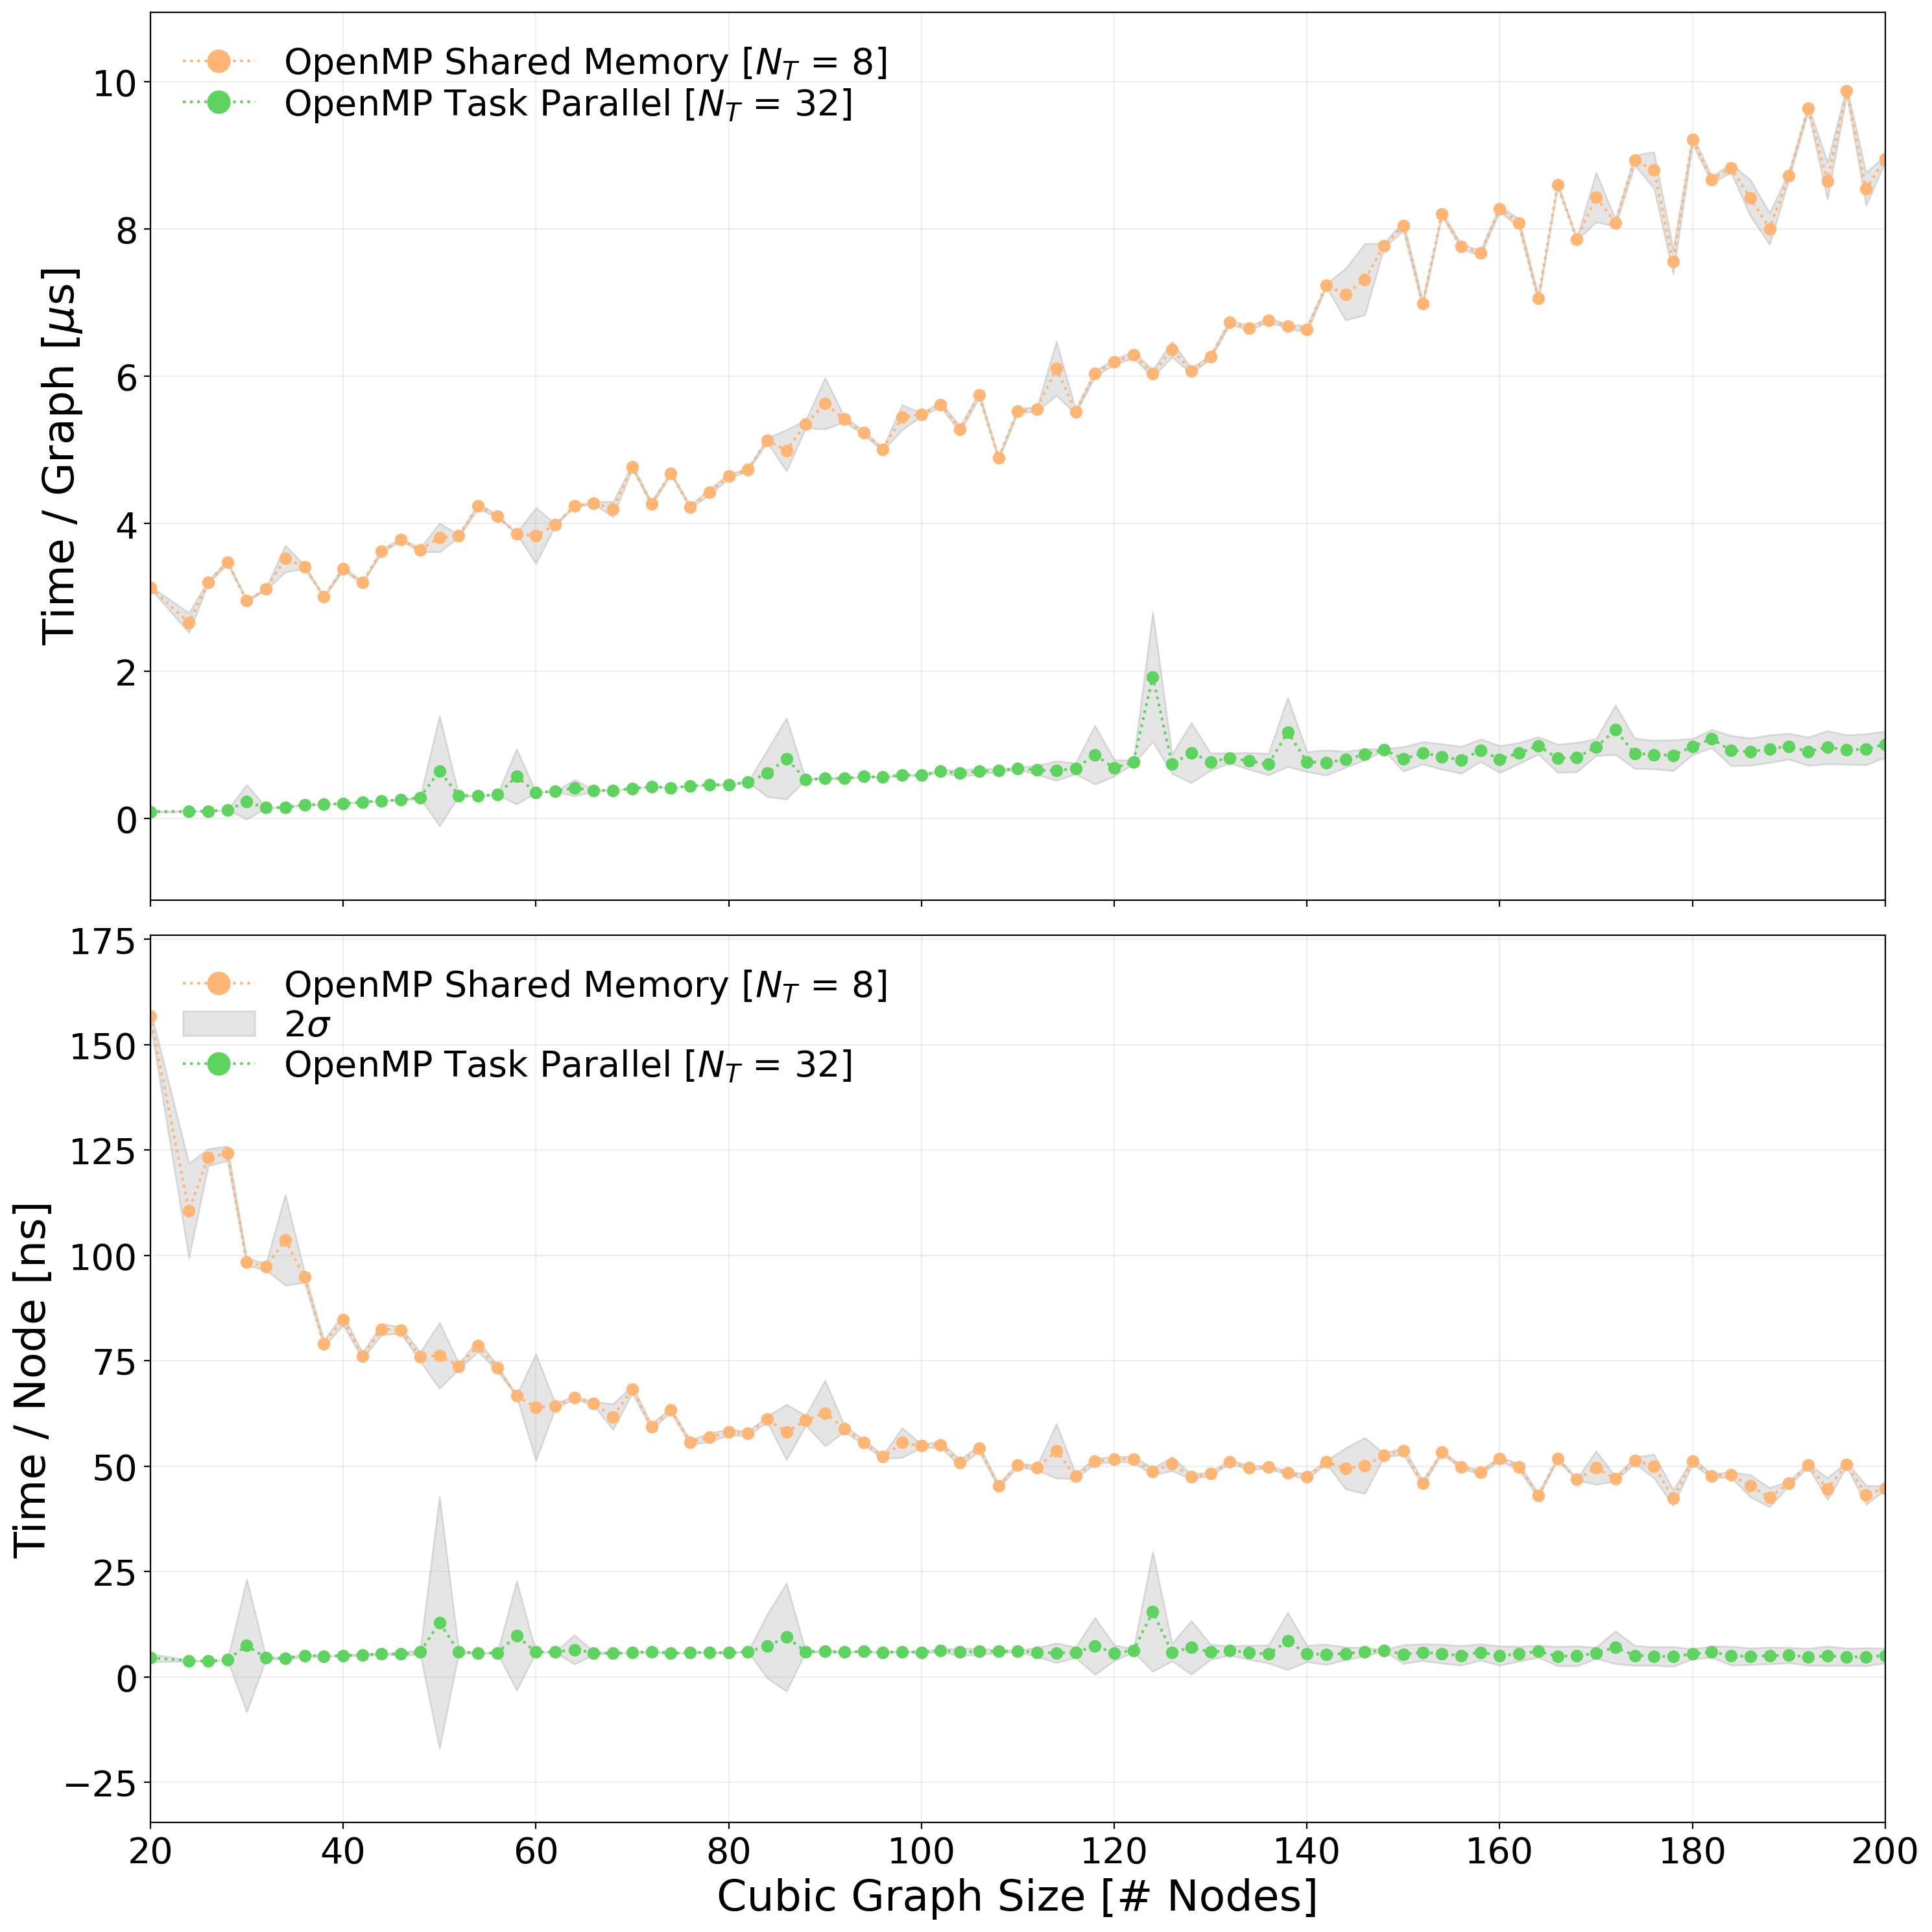

In [7]:
df_omp_shared = pd.read_csv(fname_omp_shared)
df_omp_task = pd.read_csv(fname_omp_task)

fig, ax = plt.subplots(figsize=(15,15), nrows=2, sharex=True, dpi=200)
ax[0].plot(df_omp_shared["N"].to_numpy(), df_omp_shared["T"].to_numpy()/1e3, 'o:', color=CD["Shared"], label=SharedName)
ax[0].fill_between(df_omp_shared["N"].to_numpy(), (df_omp_shared["T"].to_numpy() - df_omp_shared["TSD"].to_numpy())/1e3, (df_omp_shared["T"].to_numpy() + df_omp_shared["TSD"].to_numpy())/1e3, alpha=0.1, color='k')
ax[0].plot(df_omp_task["N"].to_numpy(), df_omp_task["T"].to_numpy()/1e3, 'o:', color=CD["Task"], label=TaskName)
ax[0].fill_between(df_omp_task["N"].to_numpy(), (df_omp_task["T"].to_numpy() - df_omp_task["TSD"].to_numpy())/1e3, (df_omp_task["T"].to_numpy() + df_omp_task["TSD"].to_numpy())/1e3, alpha=0.1, color='k')
ax[0].set_ylabel(r"Time / Graph [$\mu$s]")

ax[1].plot(df_omp_shared["N"].to_numpy(), df_omp_shared["T"].to_numpy() / df_omp_shared["N"].to_numpy(), 'o:', color=CD["Shared"], label=SharedName)
ax[1].fill_between(df_omp_shared["N"].to_numpy(), (df_omp_shared["T"].to_numpy() - df_omp_shared["TSD"].to_numpy()*2) / df_omp_shared["N"].to_numpy(), (df_omp_shared["T"].to_numpy()+df_omp_shared["TSD"].to_numpy()*2) / df_omp_shared["N"].to_numpy(), color='k', alpha=0.1, label=r"2$\sigma$")
ax[1].plot(df_omp_task["N"].to_numpy(), df_omp_task["T"].to_numpy() / df_omp_task["N"].to_numpy(), 'o:', color=CD["Task"], label=TaskName)
ax[1].fill_between(df_omp_task["N"].to_numpy(), (df_omp_task["T"].to_numpy() - df_omp_task["TSD"].to_numpy()*2) / df_omp_task["N"].to_numpy(), (df_omp_task["T"].to_numpy()+df_omp_task["TSD"].to_numpy()*2) / df_omp_task["N"].to_numpy(), color='k', alpha=0.1)
ax[1].set_ylabel(r"Time / Node [ns]")
ax[1].set_xlabel(r"Cubic Graph Size [# Nodes]")
ax[1].legend()
ax[0].legend()
plt.savefig(path + "figures/omp_benchmark.pdf", bbox_inches='tight')

### Dual GPU Benchmark of V0 and V1 Kernels (CUDA)

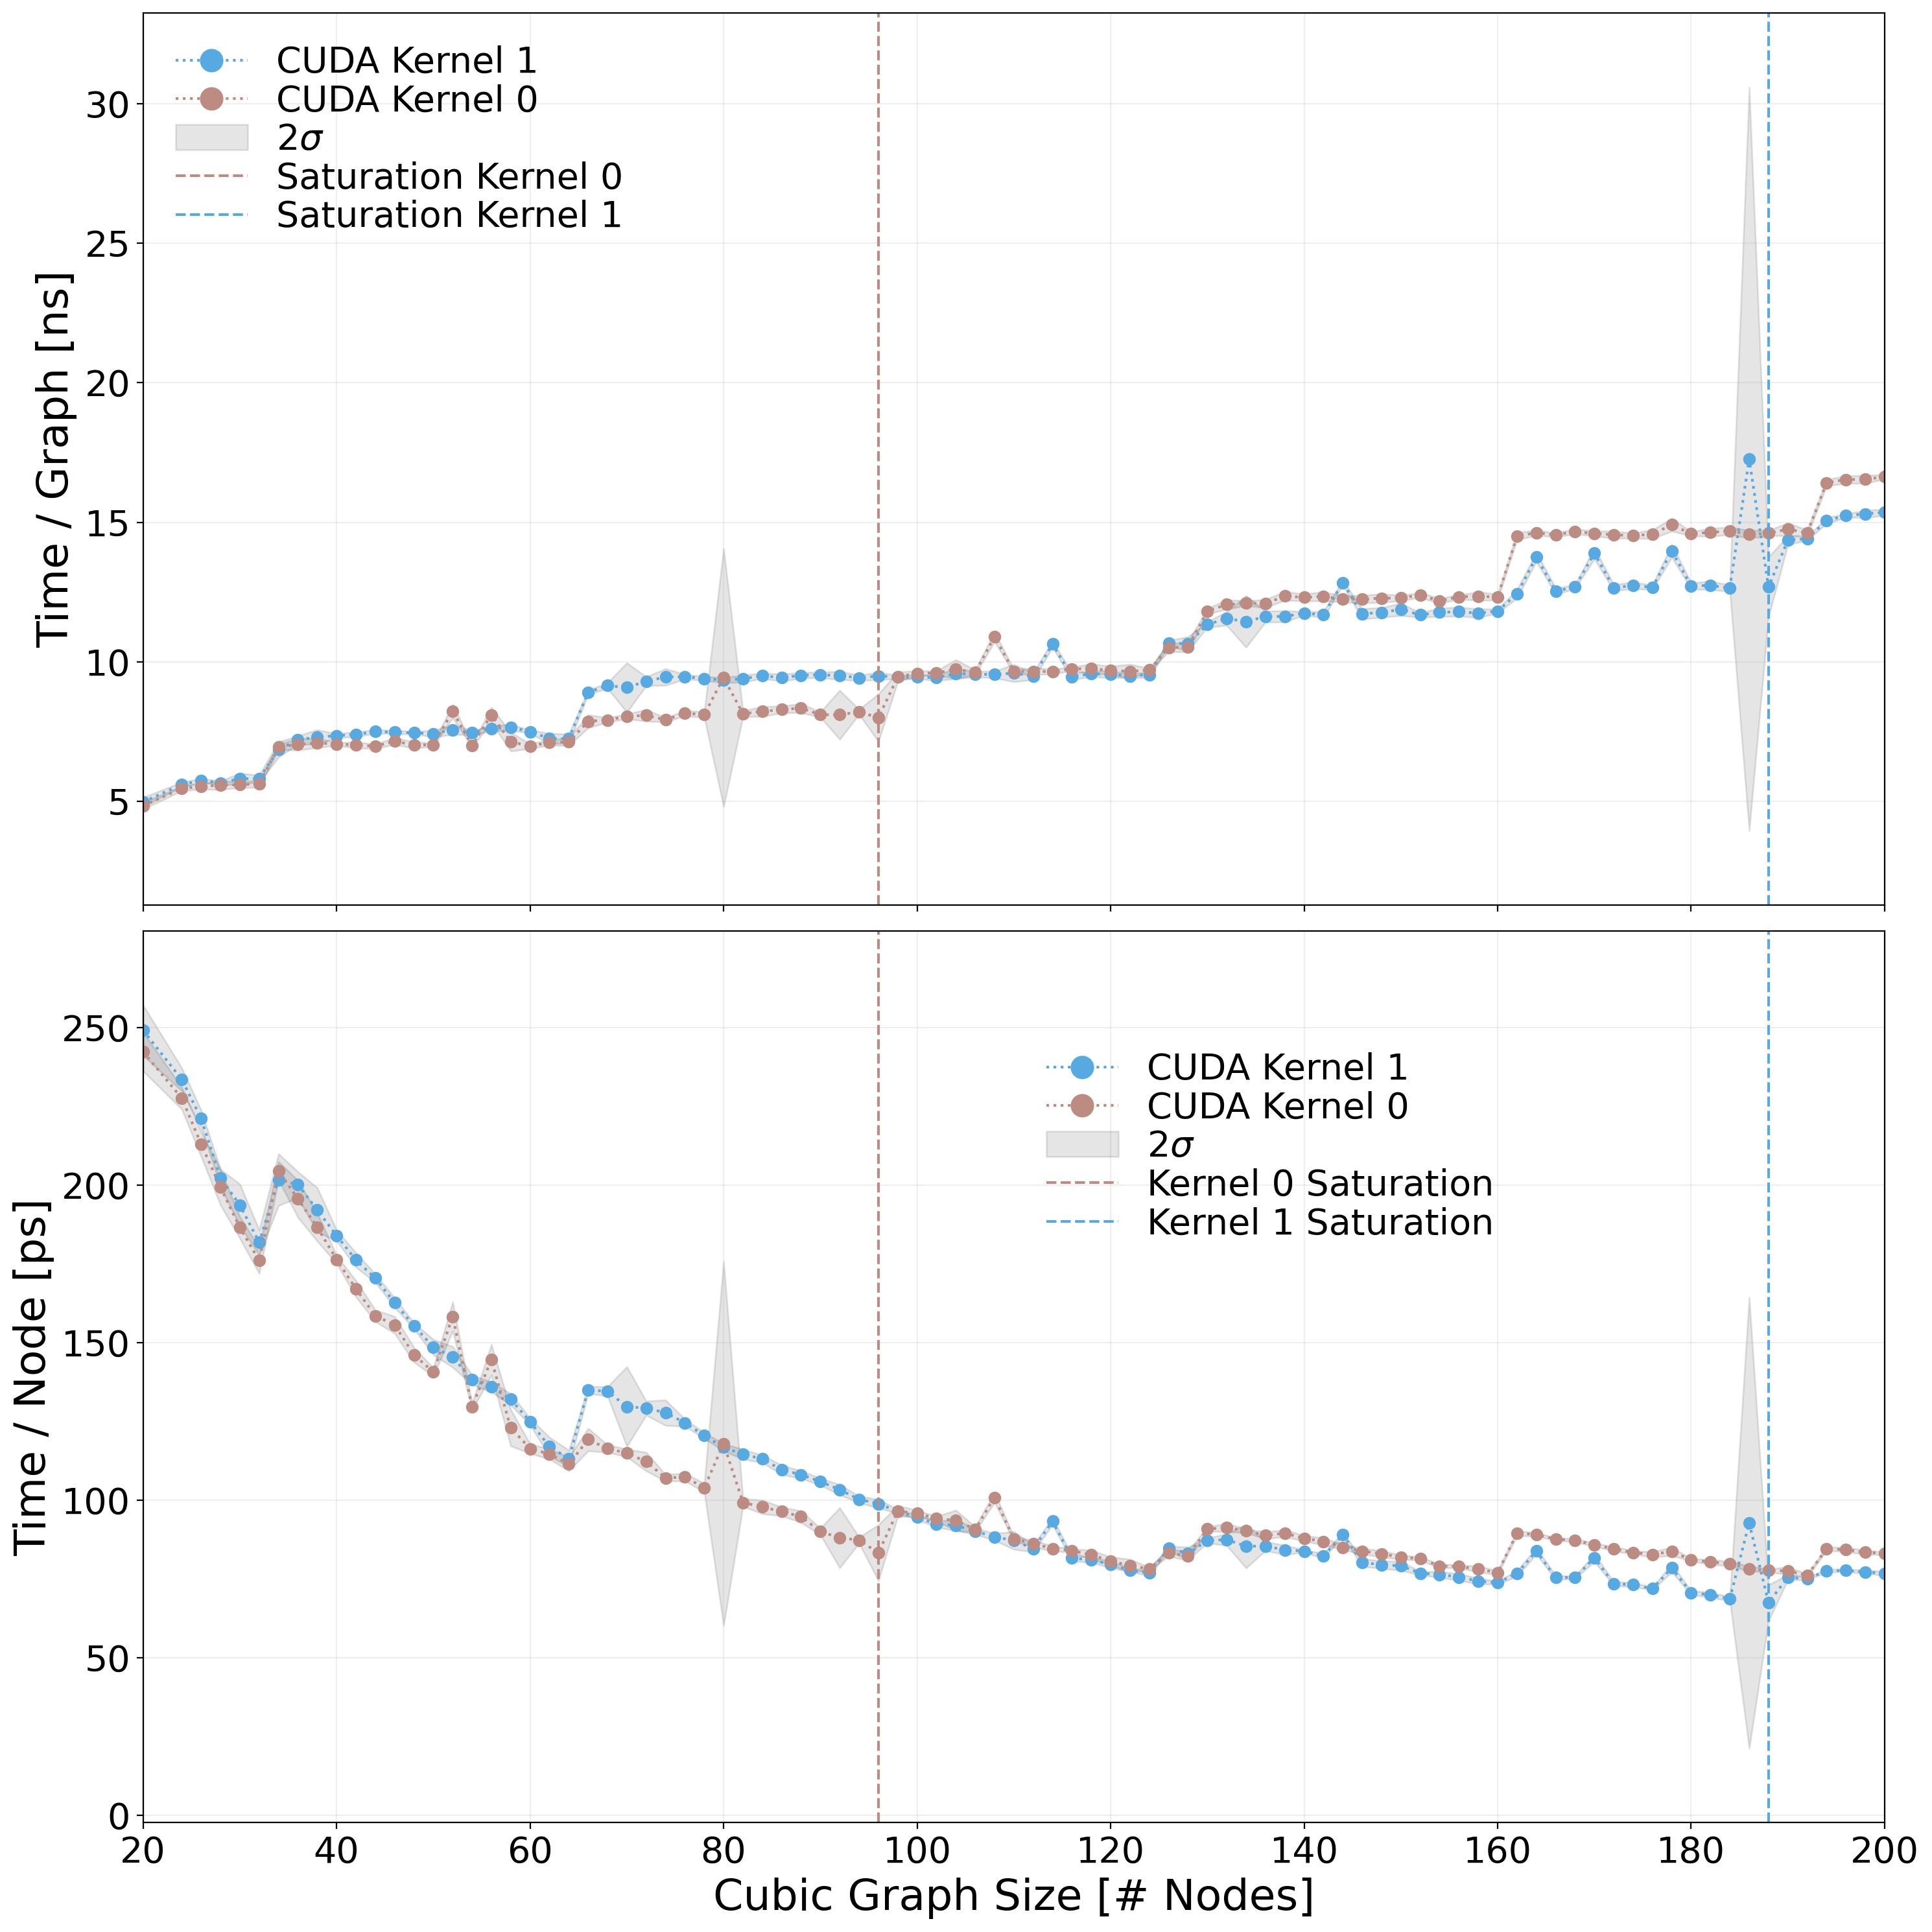

In [8]:
if(num_gpus>0):
    df0 = pd.read_csv(fname_multi_gpu_v0)
    df1 = pd.read_csv(fname_multi_gpu_v1)

    fig, ax = plt.subplots(figsize=(15,15), nrows=2, sharex=True, dpi=200)
    ax[0].plot(df0["N"].to_numpy(), df1["T"].to_numpy(), 'o:', color=CD["2 GPU_V1"], label=KName1)
    ax[0].plot(df0["N"].to_numpy(), df0["T"].to_numpy(), 'o:', color=CD["2 GPU_V0"], label=KName0)
    ax[0].fill_between(df0["N"].to_numpy(), (df0["T"].to_numpy() - df0["TSD"].to_numpy()*2), (df0["T"].to_numpy()+df0["TSD"].to_numpy()*2), color='k', alpha=0.1, label=r"2$\sigma$")
    ax[0].fill_between(df0["N"].to_numpy(), (df1["T"].to_numpy() - df1["TSD"].to_numpy()*2), (df1["T"].to_numpy()+df1["TSD"].to_numpy()*2), color='k', alpha=0.1)
    ylow = ax[0].get_ylim()[0]
    yhigh = ax[0].get_ylim()[1]
    ax[0].vlines(96, ylow, yhigh, color=CD["2 GPU_V0"], linestyle='--', label=r"Saturation Kernel 0")
    ax[0].vlines(188, ylow, yhigh, color=CD["2 GPU_V1"], linestyle='--', label=r"Saturation Kernel 1")
    ax[0].set_ylabel(r"Time / Graph [ns]")
    ax[0].set_ymargin(0.0)
    ax[0].legend(loc="upper left")

    ax[1].plot(df0["N"].to_numpy(), df1["T"].to_numpy()*1e3 / df0["N"].to_numpy(), 'o:', color=CD["2 GPU_V1"], label=KName1)
    ax[1].plot(df0["N"].to_numpy(), df0["T"].to_numpy()*1e3 / df0["N"].to_numpy(), 'o:', color=CD["2 GPU_V0"], label=KName0)
    ax[1].fill_between(df0["N"].to_numpy(), (df0["T"].to_numpy() - df0["TSD"].to_numpy()*2)*1e3 / df0["N"].to_numpy(), (df0["T"].to_numpy()+df0["TSD"].to_numpy()*2)*1e3 / df0["N"].to_numpy(), color='k', alpha=0.1, label=r"2$\sigma$")
    ax[1].fill_between(df0["N"].to_numpy(), (df1["T"].to_numpy() - df1["TSD"].to_numpy()*2)*1e3 / df0["N"].to_numpy(), (df1["T"].to_numpy()+df1["TSD"].to_numpy()*2)*1e3 / df0["N"].to_numpy(), color='k', alpha=0.1)
    ylow = ax[1].get_ylim()[0]
    yhigh = ax[1].get_ylim()[1]
    ax[1].vlines(96, ylow, yhigh, color=CD["2 GPU_V0"], linestyle='--', label=r"Kernel 0 Saturation")
    ax[1].vlines(188, ylow, yhigh, color=CD["2 GPU_V1"], linestyle='--', label=r"Kernel 1 Saturation")
    ax[1].legend(bbox_to_anchor=(0.5, 0.9))
    ax[1].set_ymargin(0.0)
    ax[1].set_xlabel(r"Cubic Graph Size [# Nodes]")
    ax[1].set_ylabel(r"Time / Node [ps]")
    plt.savefig(path + "figures/cuda_kernel_benchmark.pdf", bbox_inches='tight')

### Strong and Weak Scaling of the V1 Kernel (CUDA) from 1 to 2 GPUs 

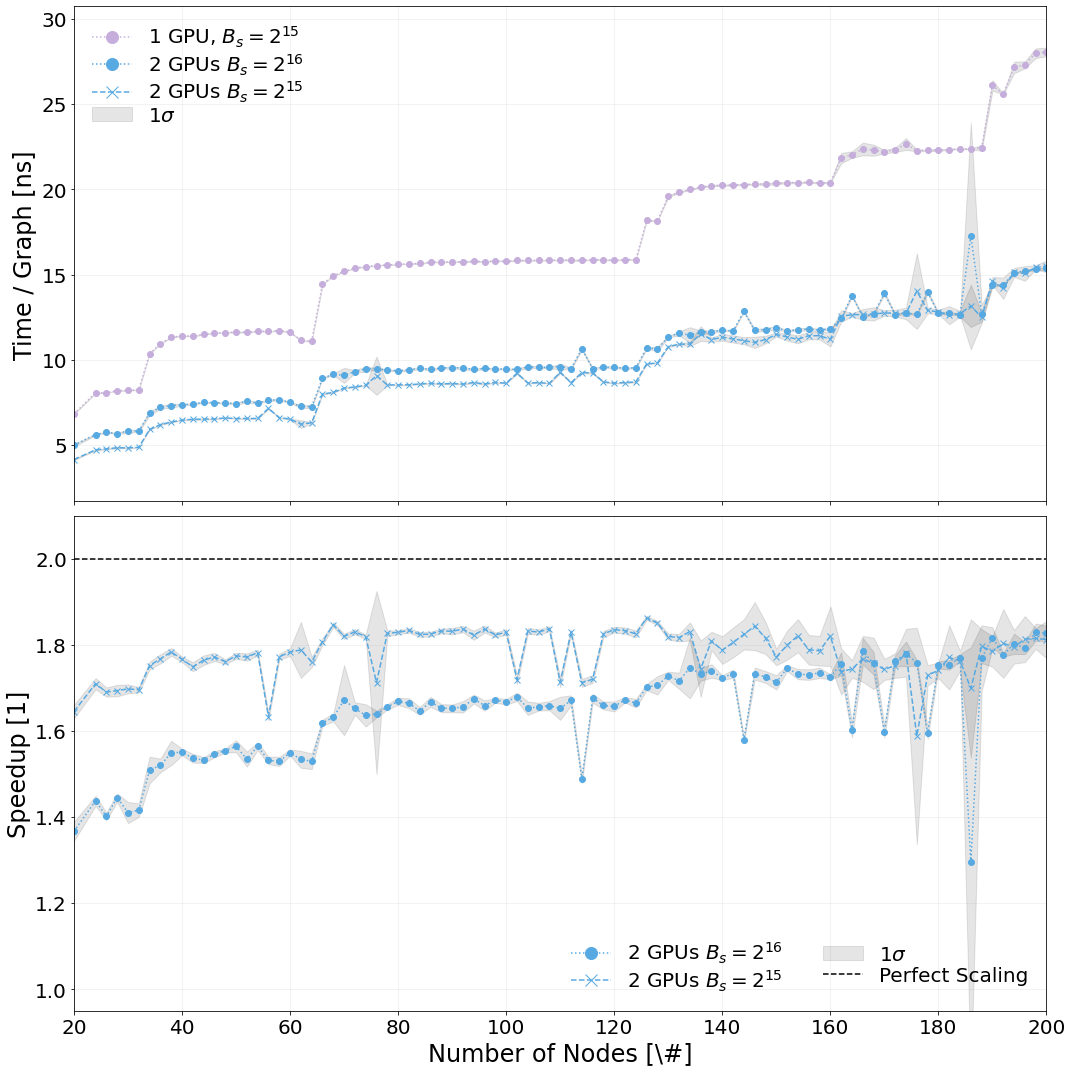

In [11]:
if(num_gpus>1):
    df1 = pd.read_csv(fname_one_gpu_v1)
    df3 = pd.read_csv(fname_multi_gpu_v1)
    df2 = pd.read_csv(fname_multi_gpu_weak)
    def std_div(a,b, a_std, b_std):
        return a/b * np.sqrt((a_std/a)**2 + (b_std/b)**2)
    fig, ax     = plt.subplots(figsize=(15, 15), nrows=2, sharex=True)
    ax[0].plot(df1["N"].to_numpy(), df1["T"].to_numpy(), 'o:',  color=CD["GPU_V1"], label=f"1 GPU, $B_s = 2^{{{20+OFFSET_BS}}}$")
    ax[0].plot(df3["N"].to_numpy(), df3["T"].to_numpy(), 'o:',  color=CD["2 GPU_V1"], label=f"2 GPUs $B_s = 2^{{{21+OFFSET_BS}}}$")
    ax[0].plot(df2["N"].to_numpy(), df2["T"].to_numpy(), 'x--',  color=CD["2 GPU_V1"], label=f"2 GPUs $B_s = 2^{{{20+OFFSET_BS}}}$")
    ax[0].fill_between(df1["N"].to_numpy(), df1["T"].to_numpy() - df1["TSD"].to_numpy()*1, df1["T"].to_numpy() + df1["TSD"].to_numpy()*1, alpha=0.1, color='k', label=r"1$\sigma$")
    ax[0].fill_between(df3["N"].to_numpy(), df3["T"].to_numpy() - df3["TSD"].to_numpy()*1, df3["T"].to_numpy() + df3["TSD"].to_numpy()*1, alpha=0.1, color='k')
    ax[0].fill_between(df2["N"].to_numpy(), df2["T"].to_numpy() - df2["TSD"].to_numpy()*1, df2["T"].to_numpy() + df2["TSD"].to_numpy()*1, alpha=0.1, color='k')
    ax[0].set_ylabel("Time / Graph [ns]")
    ax[0].legend(loc='upper left')


    #Plot speedup
    ax[1].plot(df1["N"].to_numpy(), df1["T"].to_numpy()/df3["T"].to_numpy(), 'o:',  color=CD["2 GPU_V1"], label=f"2 GPUs $B_s = 2^{{{21+OFFSET_BS}}}$")
    ax[1].plot(df1["N"].to_numpy(), df1["T"].to_numpy()/df2["T"].to_numpy(), 'x--',  color=CD["2 GPU_V1"], label=f"2 GPUs $B_s = 2^{{{20+OFFSET_BS}}}$")
    std_1 = std_div(df1["T"].to_numpy(), df3["T"].to_numpy(), df1["TSD"].to_numpy(), df3["TSD"].to_numpy())
    std_2 = std_div(df1["T"].to_numpy(), df2["T"].to_numpy(), df1["TSD"].to_numpy(), df2["TSD"].to_numpy())
    ax[1].fill_between(df1["N"].to_numpy(), df1["T"].to_numpy()/df3["T"].to_numpy() - std_1, df1["T"].to_numpy()/df3["T"].to_numpy() + std_1, alpha=0.1, color='k', label=r"1$\sigma$")
    ax[1].fill_between(df1["N"].to_numpy(), df1["T"].to_numpy()/df2["T"].to_numpy() - std_2, df1["T"].to_numpy()/df2["T"].to_numpy() + std_2, alpha=0.1, color='k')
    ax[1].hlines(2, 20, 200, linestyles='dashed', color='k', label=r"Perfect Scaling")
    ax[1].set_ylabel("Speedup [1]")
    ax[1].set_xlabel(r"Number of Nodes [\#]")
    ax[1].set_ylim(0.95,num_gpus*1.05)
    ax[1].legend(loc='lower right', ncol=2)
    plt.savefig(path + "figures/cuda_scaling.pdf", bbox_inches='tight')

### Speedup Chart of the various parallelization techniques

/tmp/ipykernel_1178357/3596356709.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([r"Baseline",r"Baseline", r"Shared [$N_T$ = " + f"{NT_shared}]", r"Task [$N_T$ = " + f"{NT_task}]", r"1 GPU", r"2 GPUs"])


(-0.5, 4.5)

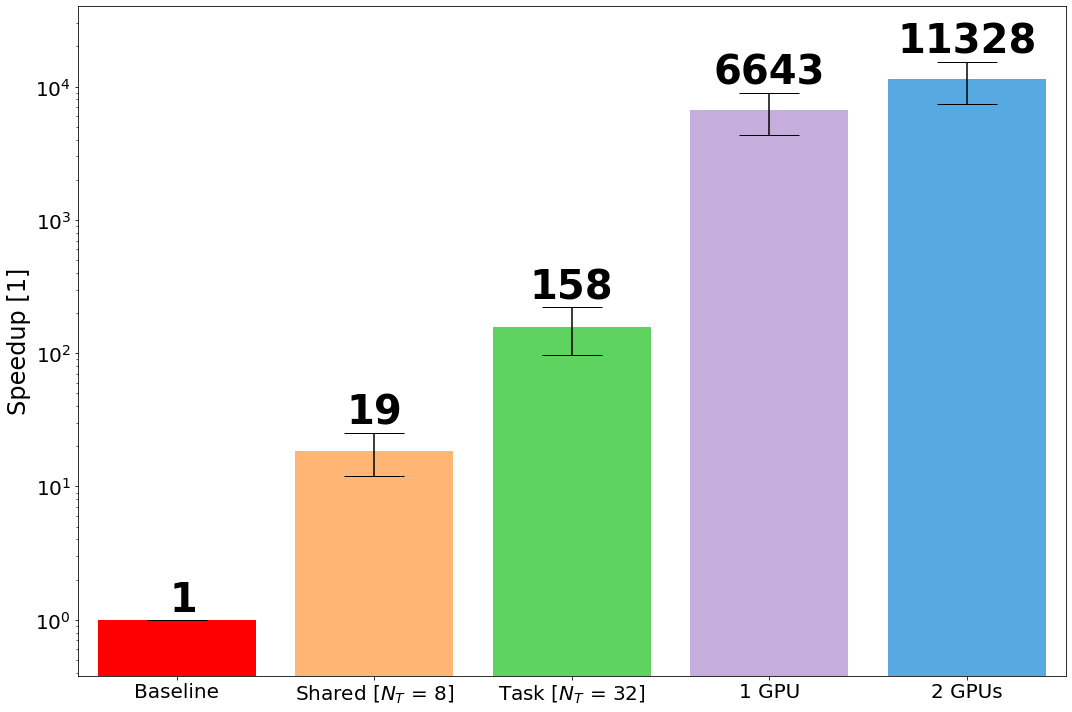

In [10]:
fig, ax     = plt.subplots(figsize=(15,10), nrows=1)
StartOffset = 36 #Start at saturation
#Plot the speedup of the different algorithms

dfbase = pd.read_csv(fname_base)
df1 = pd.read_csv(fname_omp_shared)
df2 = pd.read_csv(fname_omp_task)
df3 = pd.read_csv(fname_one_gpu_v1)
df4 = pd.read_csv(fname_multi_gpu_v1)

MeanBaseline = np.mean(dfbase["T"].to_numpy()[StartOffset:]); BaselineSD = np.std(dfbase["T"].to_numpy()[StartOffset:])
MeanShared = np.mean(df1["T"].to_numpy()[StartOffset:]); SharedSD = np.std(df1["T"].to_numpy()[StartOffset:])
MeanTask = np.mean(df2["T"].to_numpy()[StartOffset:]); TaskSD = np.std(df2["T"].to_numpy()[StartOffset:])
MeanGPU = np.mean(df3["T"].to_numpy()[StartOffset:]); GPUSD = np.std(df3["T"].to_numpy()[StartOffset:])
MeanGPU2 = np.mean(df4["T"].to_numpy()[StartOffset:]); GPU2SD = np.std(df4["T"].to_numpy()[StartOffset:])

MeanTime = np.array([MeanBaseline, MeanShared, MeanTask, MeanGPU, MeanGPU2])
MeanSD = np.array([BaselineSD, SharedSD, TaskSD, GPUSD, GPU2SD])
def std_div(a,b, a_std, b_std):
    return a/b * np.sqrt((a_std/a)**2 + (b_std/b)**2)

SpeedupSD = std_div(MeanBaseline, MeanTime, BaselineSD, MeanSD)
SpeedupSD[0] = 0
Speedup = MeanBaseline / MeanTime


color_bar = [CD["Baseline"], CD["Shared"], CD["Task"], CD["GPU_V1"], CD["2 GPU_V1"]]


if num_gpus>1:
    p1 = ax.bar(np.arange(5), Speedup, color= color_bar, yerr=SpeedupSD, capsize=30)
    ax.bar_label(p1,label_type='edge',fmt="%2.0f",color="black",weight="bold", fontsize=40, alpha=1.0)
elif num_gpus>0:
    p1 = ax.bar(np.arange(4), Speedup[:-1], color= color_bar[:-1], yerr=SpeedupSD[:-1], capsize=30)
    ax.bar_label(p1,label_type='edge',fmt="%2.0f",color="black",weight="bold", fontsize=40, alpha=1.0)
else:
    p1 = ax.bar(np.arange(3), Speedup[:-2], color= color_bar[:-2], yerr=SpeedupSD[:-2], capsize=30)
    ax.bar_label(p1,label_type='edge',fmt="%2.0f",color="black",weight="bold", fontsize=40, alpha=1.0)
ax.set_yscale("log")
ax.set_ylabel(r"Speedup [1]")
ax.grid(False)
ax.set_xticklabels([r"Baseline",r"Baseline", r"Shared [$N_T$ = " + f"{NT_shared}]", r"Task [$N_T$ = " + f"{NT_task}]", r"1 GPU", r"2 GPUs"])

ax.set_xlim(-0.5,4.5)